In [12]:
import tensorflow as tf
# from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
from PIL import Image
from scipy import misc
import os
# import imageio
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
batch_size = 100
g_dim = 128

ls = np.array(os.listdir("./img_align_celeba"))

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 2, 2, 1], padding = 'SAME')
def deconv2d(x, W, output_shape):
    return tf.nn.conv2d_transpose(x, W, output_shape, strides = [1, 2, 2, 1], padding = 'SAME')


In [14]:
def get_image(img_path):
#     img = misc.imread(img_path)/255. - 0.5
    img = misc.imread(img_path)
#     img = img[..., ::-1]  # rgb to bgr
    return img

def batch(batch_size, ls):
    index = (np.random.sample(batch_size)*202599).astype(int)
    ls_x = ls[[index]]
    return np.array([np.reshape(misc.imread("./img_align_celeba/"+x), 116412)/255. for x in ls_x])

class layer:
    def __init__(self, in_size, out_size):
        self.W = tf.Variable(tf.random_normal([in_size, out_size], mean=0.0, stddev=0.1))
        self.b = tf.Variable(tf.random_normal([1, out_size], mean=0.0, stddev=0.1))
    def output(self, inputs, activation_function=None):
        if activation_function == None:
            return tf.matmul(inputs, self.W) + self.b
        else :
            return activation_function(tf.matmul(inputs, self.W) + self.b)

def weight_variable(shape):
    initial = tf.random_normal(shape, mean=0.0, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.random_normal(shape, mean=0.0, stddev=0.1)
    return tf.Variable(initial)

In [20]:
layer_e = layer(28*23*64, g_dim)
layer_d = layer(g_dim, 28*23*64)

encoder_var = {
    "W_e_conv1" : weight_variable([3,3, 3,16]),
    "W_e_conv2" : weight_variable([3,3,16,32]),
    "W_e_conv3" : weight_variable([3,3,32,64]),
#     "W_e_conv3" : weight_variable([3,3,64,128]),
    "b_e_conv1" : bias_variable([16]),   
    "b_e_conv2" : bias_variable([32]),
    "b_e_conv3" : bias_variable([64])
#     "b_e_conv3" : bias_variable([128])
}

decoder_var = {
    "W_d_conv1" : weight_variable([3,3,32,64]),
    "W_d_conv2" : weight_variable([3,3,16,32]),
    "W_d_conv3" : weight_variable([3,3, 3,16]),
    "b_d_conv1" : bias_variable([32]),
    "b_d_conv2" : bias_variable([16]),
    "b_d_conv3" : bias_variable([3])
}

generator_var = {
    "W_d_conv1" : weight_variable([3,3,32,64]),
    "W_d_conv2" : weight_variable([3,3,16,32]),
    "W_d_conv3" : weight_variable([3,3, 3,16]),
    "b_d_conv1" : bias_variable([32]),
    "b_d_conv2" : bias_variable([16]),
    "b_d_conv3" : bias_variable([3])
}

var_d = [encoder_var[e] for e in encoder_var]+[decoder_var[d] for d in decoder_var]
var_g = [generator_var[g] for g in generator_var]


In [21]:
def encoder(x):
    x_origin = tf.reshape(x, [-1,218,178,3])      #28x28x1
    h_e_conv1 = tf.nn.relu(tf.add(conv2d(x_origin, encoder_var["W_e_conv1"]), encoder_var["b_e_conv1"]))     #14x14x16
    h_e_conv2 = tf.nn.relu(tf.add(conv2d(h_e_conv1, encoder_var["W_e_conv2"]), encoder_var["b_e_conv2"]))    #7x7x32
    h_e_conv3 = tf.nn.relu(tf.add(conv2d(h_e_conv2, encoder_var["W_e_conv3"]), encoder_var["b_e_conv3"]))    #4x4x64
    h_e_conv3_reshape = tf.reshape(h_e_conv3, [-1,28*23*64])
    h_e_layer = layer_e.output(h_e_conv3_reshape, tf.nn.relu)
#     h_e_layer = layer_e.output(h_e_conv3_reshape, tf.nn.sigmoid)
    return h_e_layer
    
def decoder(z):
    h_d_layer = layer_d.output(z, tf.nn.relu)
#     h_d_layer = layer_d.output(z, tf.nn.sigmoid)
    h_d_layer_reshape = tf.reshape(h_d_layer, [-1,28,23,64])
    
    output_shape_d_conv1 = tf.stack([tf.shape(z)[0], 55, 45, 32])
    h_d_conv1 = tf.nn.relu(deconv2d(h_d_layer_reshape, decoder_var["W_d_conv1"], output_shape_d_conv1)+decoder_var["b_d_conv1"])

    output_shape_d_conv1 = tf.stack([tf.shape(z)[0], 109, 89, 16])
    h_d_conv2 = tf.nn.relu(deconv2d(h_d_conv1, decoder_var["W_d_conv2"], output_shape_d_conv1)+decoder_var["b_d_conv2"])

    output_shape_d_conv2 = tf.stack([tf.shape(z)[0], 218, 178, 3])
    h_d_conv3 = tf.nn.relu(deconv2d(h_d_conv2, decoder_var["W_d_conv3"], output_shape_d_conv2)+decoder_var["b_d_conv3"])
    return h_d_conv3

def generator(z):
    h_d_layer = layer_d.output(z, tf.nn.relu)
#     h_d_layer = layer_d.output(z, tf.nn.sigmoid)
    h_d_layer_reshape = tf.reshape(h_d_layer, [-1,28,23,64])
    
    output_shape_d_conv1 = tf.stack([tf.shape(z)[0], 55, 45, 32])
    h_d_conv1 = tf.nn.relu(deconv2d(h_d_layer_reshape, generator_var["W_d_conv1"], output_shape_d_conv1)+generator_var["b_d_conv1"])

    output_shape_d_conv1 = tf.stack([tf.shape(z)[0], 109, 89, 16])
    h_d_conv2 = tf.nn.relu(deconv2d(h_d_conv1, generator_var["W_d_conv2"], output_shape_d_conv1)+generator_var["b_d_conv2"])

    output_shape_d_conv2 = tf.stack([tf.shape(z)[0], 218, 178, 3])
    h_d_conv3 = tf.nn.relu(deconv2d(h_d_conv2, generator_var["W_d_conv3"], output_shape_d_conv2)+generator_var["b_d_conv3"])
    return h_d_conv3

def discriminator(x):
    return decoder(encoder(x))

In [22]:
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

def loss(x):
#     return tf.reduce_mean(tf.pow(tf.reshape(x, [-1, 784]) - tf.reshape(discriminator(x), [-1, 784]), 2))
    return tf.reduce_mean(tf.abs(tf.reshape(x, [-1, 116412]) - tf.reshape(discriminator(x), [-1, 116412])))
#     return tf.pow(tf.reshape(x, [-1, 784]) - tf.reshape(discriminator(x), [-1, 784]), 2)

In [23]:
x_d = tf.placeholder(tf.float32, shape = [None, 116412])
x_g = tf.placeholder(tf.float32, shape = [None, g_dim])


gamma = 0.5
# k_t = 0.
k_t = tf.Variable(0.0, tf.float32)

# d_loss = loss(x_d)-k_t*loss(generator(x_g))
# d_loss = loss(x_d)
d_loss = tf.reduce_mean(loss(x_d)-k_t*loss(generator(x_g)))
# g_loss = loss(generator(x_g))
g_loss = tf.reduce_mean(loss(generator(x_g)))

g_sample = generator(x_g)

M_global = loss(x_d) + tf.abs(gamma*loss(x_d) - loss(generator(x_g)))

d_optimizer = tf.train.AdamOptimizer(0.00001).minimize(d_loss, var_list= var_d)
g_optimizer = tf.train.AdamOptimizer(0.00001).minimize(g_loss, var_list= var_g)

# balancer = gamma*loss(x_d) - loss(generator(x_g))
balancer = tf.reduce_mean(gamma*loss(x_d) - loss(generator(x_g)))
update_k = k_t.assign(k_t + 0.001 * balancer)



In [24]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

for step in range(1001):
    batch_x = batch(batch_size, ls)
    z_D = sample_Z(batch_size, g_dim)
    sess.run([d_optimizer, g_optimizer], feed_dict={x_d: batch_x, x_g: z_D})
    z_G = sample_Z(batch_size, g_dim)
    sess.run(g_optimizer, feed_dict={x_g: z_G})
#     k_t = np.maximum(np.minimum(1., k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: z_G}))), 0.)
    sess.run(update_k, feed_dict={x_d: batch_x, x_g: z_G})
    if step%100==0:
        d_loss_train, g_loss_train, M_global_train = sess.run([d_loss, g_loss, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#         print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', sess.run(k_t),"M_global:", M_global_train

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.


step: 0  d-loss: 0.425209  g-loss: 0.164476 k_t: 4.82592e-05 M_global: 0.473348
step: 100  d-loss: 0.397492  g-loss: 0.119339 k_t: 0.00653989 M_global: 0.478069
step: 200  d-loss: 0.387458  g-loss: 0.0987145 k_t: 0.0147374 M_global: 0.484655
step: 300  d-loss: 0.36524  g-loss: 0.089813 k_t: 0.0237308 M_global: 0.461244
step: 400  d-loss: 0.355099  g-loss: 0.0888103 k_t: 0.0329343 M_global: 0.448226
step: 500  d-loss: 0.368972  g-loss: 0.0888146 k_t: 0.0418628 M_global: 0.470221
step: 600  d-loss: 0.351616  g-loss: 0.0892332 k_t: 0.0504478 M_global: 0.444943
step: 700  d-loss: 0.33543  g-loss: 0.0919426 k_t: 0.0585509 M_global: 0.419278
step: 800  d-loss: 0.343131  g-loss: 0.0955117 k_t: 0.0659916 M_global: 0.42864
step: 900  d-loss: 0.328512  g-loss: 0.103448 k_t: 0.0726798 M_global: 0.400599
step: 1000  d-loss: 0.320257  g-loss: 0.109453 k_t: 0.0783995 M_global: 0.383804


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.


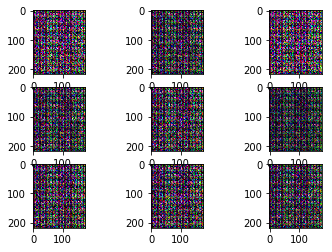

In [28]:
# zz = sample_Z(batch_size, g_dim)
# gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(g_sample, feed_dict = {x_g: sample_Z(batch_size, g_dim)})
gg = sess.run(discriminator(x_d), feed_dict = {x_d: batch(20, ls)})
gg_pic = np.array([np.reshape(m,(218,178,3)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j])

In [29]:
for step in range(5001):
    batch_x = batch(batch_size, ls)
    z_D = sample_Z(batch_size, g_dim)
    sess.run([d_optimizer, g_optimizer], feed_dict={x_d: batch_x, x_g: z_D})
    z_G = sample_Z(batch_size, g_dim)
    sess.run(g_optimizer, feed_dict={x_g: z_G})
#     k_t = np.maximum(np.minimum(1., k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: z_G}))), 0.)
    sess.run(update_k, feed_dict={x_d: batch_x, x_g: z_G})
    if step%100==0:
        d_loss_train, g_loss_train, M_global_train = sess.run([d_loss, g_loss, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#         print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', sess.run(k_t),"M_global:", M_global_train

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.


step: 0  d-loss: 0.313273  g-loss: 0.109739 k_t: 0.07845 M_global: 0.373084
step: 100  d-loss: 0.326014  g-loss: 0.115528 k_t: 0.0832945 M_global: 0.387928
step: 200  d-loss: 0.30801  g-loss: 0.122036 k_t: 0.0873335 M_global: 0.355966
step: 300  d-loss: 0.2933  g-loss: 0.126139 k_t: 0.0905692 M_global: 0.330948
step: 400  d-loss: 0.297555  g-loss: 0.130144 k_t: 0.0931403 M_global: 0.33437
step: 500  d-loss: 0.287902  g-loss: 0.135198 k_t: 0.0950731 M_global: 0.315936
step: 600  d-loss: 0.279555  g-loss: 0.140308 k_t: 0.0961295 M_global: 0.299256
step: 700  d-loss: 0.274465  g-loss: 0.135886 k_t: 0.096835 M_global: 0.295549
step: 800  d-loss: 0.267789  g-loss: 0.131037 k_t: 0.0979788 M_global: 0.289904
step: 900  d-loss: 0.269997  g-loss: 0.134626 k_t: 0.0989329 M_global: 0.290347
step: 1000  d-loss: 0.257429  g-loss: 0.14466 k_t: 0.0988607 M_global: 0.280525
step: 1100  d-loss: 0.255127  g-loss: 0.156275 k_t: 0.0973937 M_global: 0.291448
step: 1200  d-loss: 0.247866  g-loss: 0.154303 k

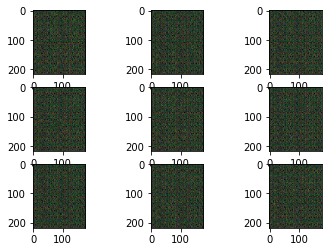

In [31]:
# zz = sample_Z(batch_size, g_dim)
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(g_sample, feed_dict = {x_g: sample_Z(batch_size, g_dim)})
# gg = sess.run(discriminator(x_d), feed_dict = {x_d: batch(20, ls)})
gg_pic = np.array([np.reshape(m,(218,178,3)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j])

In [32]:
for step in range(10001):
    batch_x = batch(batch_size, ls)
    z_D = sample_Z(batch_size, g_dim)
    sess.run([d_optimizer, g_optimizer], feed_dict={x_d: batch_x, x_g: z_D})
    z_G = sample_Z(batch_size, g_dim)
    sess.run(g_optimizer, feed_dict={x_g: z_G})
#     k_t = np.maximum(np.minimum(1., k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: z_G}))), 0.)
    sess.run(update_k, feed_dict={x_d: batch_x, x_g: z_G})
    if step%100==0:
        d_loss_train, g_loss_train, M_global_train = sess.run([d_loss, g_loss, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#         print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', sess.run(k_t),"M_global:", M_global_train

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.


step: 0  d-loss: 0.222704  g-loss: 0.0672716 k_t: 0.194727 M_global: 0.286434
step: 100  d-loss: 0.21987  g-loss: 0.0590881 k_t: 0.199841 M_global: 0.288428
step: 200  d-loss: 0.216791  g-loss: 0.0521569 k_t: 0.20569 M_global: 0.289122
step: 300  d-loss: 0.213965  g-loss: 0.0464183 k_t: 0.212166 M_global: 0.289301
step: 400  d-loss: 0.220575  g-loss: 0.0419713 k_t: 0.21914 M_global: 0.302687
step: 500  d-loss: 0.219795  g-loss: 0.0387203 k_t: 0.226414 M_global: 0.304123
step: 600  d-loss: 0.216786  g-loss: 0.036536 k_t: 0.233963 M_global: 0.301465
step: 700  d-loss: 0.208969  g-loss: 0.0477656 k_t: 0.241473 M_global: 0.282989
step: 800  d-loss: 0.173503  g-loss: 0.356562 k_t: 0.232999 M_global: 0.484853
step: 900  d-loss: 0.206787  g-loss: 0.322981 k_t: 0.210537 M_global: 0.460374
step: 1000  d-loss: 0.206198  g-loss: 0.24882 k_t: 0.196142 M_global: 0.376321
step: 1100  d-loss: 0.177995  g-loss: 0.364144 k_t: 0.177654 M_global: 0.485487
step: 1200  d-loss: 0.196113  g-loss: 0.322721 k_

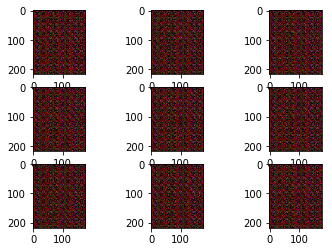

In [33]:
# zz = sample_Z(batch_size, g_dim)
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(g_sample, feed_dict = {x_g: sample_Z(batch_size, g_dim)})
# gg = sess.run(discriminator(x_d), feed_dict = {x_d: batch(20, ls)})
gg_pic = np.array([np.reshape(m,(218,178,3)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.


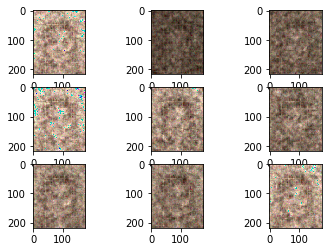

In [34]:
gg = sess.run(discriminator(x_d), feed_dict = {x_d: batch(20, ls)})
gg_pic = np.array([np.reshape(m,(218,178,3)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j])

In [35]:
for step in range(10001):
    batch_x = batch(batch_size, ls)
    z_D = sample_Z(batch_size, g_dim)
    sess.run([d_optimizer, g_optimizer], feed_dict={x_d: batch_x, x_g: z_D})
    z_G = sample_Z(batch_size, g_dim)
    sess.run(g_optimizer, feed_dict={x_g: z_G})
#     k_t = np.maximum(np.minimum(1., k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: z_G}))), 0.)
    sess.run(update_k, feed_dict={x_d: batch_x, x_g: z_G})
    if step%100==0:
        d_loss_train, g_loss_train, M_global_train = sess.run([d_loss, g_loss, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#         print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', sess.run(k_t),"M_global:", M_global_train

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.


step: 0  d-loss: 0.208211  g-loss: 0.173838 k_t: 0.0610782 M_global: 0.283252
step: 100  d-loss: 0.215789  g-loss: 0.12719 k_t: 0.0569551 M_global: 0.238707
step: 200  d-loss: 0.215199  g-loss: 0.105892 k_t: 0.0562551 M_global: 0.225841
step: 300  d-loss: 0.208982  g-loss: 0.0952643 k_t: 0.0569166 M_global: 0.226342
step: 400  d-loss: 0.213403  g-loss: 0.088017 k_t: 0.0583371 M_global: 0.239789
step: 500  d-loss: 0.203305  g-loss: 0.0831182 k_t: 0.060335 M_global: 0.229361
step: 600  d-loss: 0.20212  g-loss: 0.0810719 k_t: 0.0626977 M_global: 0.229733
step: 700  d-loss: 0.206322  g-loss: 0.0809992 k_t: 0.0651455 M_global: 0.236399
step: 800  d-loss: 0.207571  g-loss: 0.0806727 k_t: 0.0675536 M_global: 0.238858
step: 900  d-loss: 0.206724  g-loss: 0.0761909 k_t: 0.0701773 M_global: 0.241916
step: 1000  d-loss: 0.204091  g-loss: 0.0699993 k_t: 0.0733424 M_global: 0.243839
step: 1100  d-loss: 0.199135  g-loss: 0.0648026 k_t: 0.0770437 M_global: 0.241389
step: 1200  d-loss: 0.196751  g-los

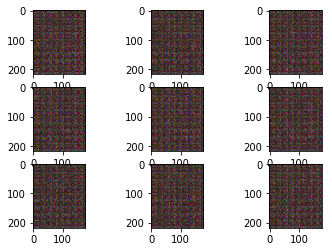

In [36]:
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(g_sample, feed_dict = {x_g: sample_Z(batch_size, g_dim)})
# gg = sess.run(discriminator(x_d), feed_dict = {x_d: batch(20, ls)})
gg_pic = np.array([np.reshape(m,(218,178,3)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.


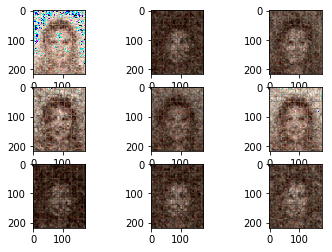

In [37]:
# gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(g_sample, feed_dict = {x_g: sample_Z(batch_size, g_dim)})
gg = sess.run(discriminator(x_d), feed_dict = {x_d: batch(20, ls)})
gg_pic = np.array([np.reshape(m,(218,178,3)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j])

In [38]:
for step in range(20001):
    batch_x = batch(batch_size, ls)
    z_D = sample_Z(batch_size, g_dim)
    sess.run([d_optimizer, g_optimizer], feed_dict={x_d: batch_x, x_g: z_D})
    z_G = sample_Z(batch_size, g_dim)
    sess.run(g_optimizer, feed_dict={x_g: z_G})
#     k_t = np.maximum(np.minimum(1., k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: z_G}))), 0.)
    sess.run(update_k, feed_dict={x_d: batch_x, x_g: z_G})
    if step%100==0:
        d_loss_train, g_loss_train, M_global_train = sess.run([d_loss, g_loss, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#         print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', sess.run(k_t),"M_global:", M_global_train

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.


step: 0  d-loss: 0.178894  g-loss: 0.099006 k_t: 0.0976002 M_global: 0.193284
step: 100  d-loss: 0.186517  g-loss: 0.0959919 k_t: 0.0974915 M_global: 0.197821
step: 200  d-loss: 0.182263  g-loss: 0.093396 k_t: 0.0976607 M_global: 0.19368
step: 300  d-loss: 0.1857  g-loss: 0.0919344 k_t: 0.0980397 M_global: 0.200135
step: 400  d-loss: 0.185494  g-loss: 0.0902548 k_t: 0.0985787 M_global: 0.201333
step: 500  d-loss: 0.1813  g-loss: 0.0886494 k_t: 0.0992161 M_global: 0.196494
step: 600  d-loss: 0.185653  g-loss: 0.087833 k_t: 0.0999938 M_global: 0.203821
step: 700  d-loss: 0.182318  g-loss: 0.0865387 k_t: 0.100885 M_global: 0.200034
step: 800  d-loss: 0.18313  g-loss: 0.085425 k_t: 0.101864 M_global: 0.202323
step: 900  d-loss: 0.187319  g-loss: 0.0833535 k_t: 0.102974 M_global: 0.2105
step: 1000  d-loss: 0.173442  g-loss: 0.0803369 k_t: 0.104302 M_global: 0.192395
step: 1100  d-loss: 0.174078  g-loss: 0.0765174 k_t: 0.106005 M_global: 0.196767
step: 1200  d-loss: 0.176193  g-loss: 0.06877

step: 10200  d-loss: 0.175721  g-loss: 0.0899311 k_t: 0.0371241 M_global: 0.179461
step: 10300  d-loss: 0.179589  g-loss: 0.0942194 k_t: 0.0367969 M_global: 0.185747
step: 10400  d-loss: 0.179957  g-loss: 0.0987749 k_t: 0.0360826 M_global: 0.190535
step: 10500  d-loss: 0.179824  g-loss: 0.103781 k_t: 0.0348643 M_global: 0.195503
step: 10600  d-loss: 0.179429  g-loss: 0.107986 k_t: 0.033187 M_global: 0.199492
step: 10700  d-loss: 0.171819  g-loss: 0.110754 k_t: 0.0311109 M_global: 0.198387
step: 10800  d-loss: 0.172721  g-loss: 0.1084 k_t: 0.0289269 M_global: 0.196329
step: 10900  d-loss: 0.176712  g-loss: 0.105748 k_t: 0.0270465 M_global: 0.195533
step: 11000  d-loss: 0.169655  g-loss: 0.104106 k_t: 0.0254214 M_global: 0.190257
step: 11100  d-loss: 0.172453  g-loss: 0.0995369 k_t: 0.0241518 M_global: 0.186965
step: 11200  d-loss: 0.172502  g-loss: 0.0874664 k_t: 0.0236655 M_global: 0.174752
step: 11300  d-loss: 0.180812  g-loss: 0.0833558 k_t: 0.0240481 M_global: 0.190869
step: 11400  

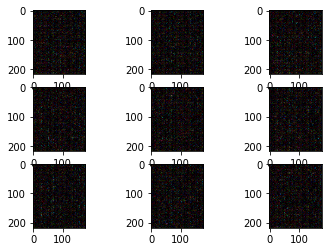

In [39]:
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(g_sample, feed_dict = {x_g: sample_Z(batch_size, g_dim)})
# gg = sess.run(discriminator(x_d), feed_dict = {x_d: batch(20, ls)})
gg_pic = np.array([np.reshape(m,(218,178,3)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.


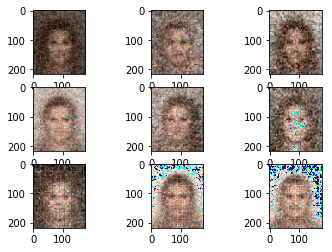

In [40]:
# gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(g_sample, feed_dict = {x_g: sample_Z(batch_size, g_dim)})
gg = sess.run(discriminator(x_d), feed_dict = {x_d: batch(20, ls)})
gg_pic = np.array([np.reshape(m,(218,178,3)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j])

In [41]:
for step in range(20001):
    batch_x = batch(batch_size, ls)
    z_D = sample_Z(batch_size, g_dim)
    sess.run([d_optimizer, g_optimizer], feed_dict={x_d: batch_x, x_g: z_D})
    z_G = sample_Z(batch_size, g_dim)
    sess.run(g_optimizer, feed_dict={x_g: z_G})
#     k_t = np.maximum(np.minimum(1., k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: z_G}))), 0.)
    sess.run(update_k, feed_dict={x_d: batch_x, x_g: z_G})
    if step%100==0:
        d_loss_train, g_loss_train, M_global_train = sess.run([d_loss, g_loss, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#         print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', sess.run(k_t),"M_global:", M_global_train

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.


step: 0  d-loss: 0.168085  g-loss: 0.0862439 k_t: 0.0251333 M_global: 0.17137
step: 100  d-loss: 0.169961  g-loss: 0.0867952 k_t: 0.0250169 M_global: 0.172861
step: 200  d-loss: 0.166094  g-loss: 0.0851584 k_t: 0.024868 M_global: 0.169264
step: 300  d-loss: 0.170632  g-loss: 0.0868415 k_t: 0.0246932 M_global: 0.17323
step: 400  d-loss: 0.17585  g-loss: 0.0852704 k_t: 0.0246162 M_global: 0.181653
step: 500  d-loss: 0.16087  g-loss: 0.0829309 k_t: 0.0246744 M_global: 0.164389
step: 600  d-loss: 0.16496  g-loss: 0.0847167 k_t: 0.0247495 M_global: 0.168245
step: 700  d-loss: 0.167695  g-loss: 0.083919 k_t: 0.0248491 M_global: 0.170752
step: 800  d-loss: 0.166466  g-loss: 0.0835668 k_t: 0.0249168 M_global: 0.169256
step: 900  d-loss: 0.164044  g-loss: 0.0835925 k_t: 0.0249594 M_global: 0.166658
step: 1000  d-loss: 0.164739  g-loss: 0.0840683 k_t: 0.025038 M_global: 0.16749
step: 1100  d-loss: 0.161182  g-loss: 0.0845845 k_t: 0.025054 M_global: 0.166235
step: 1200  d-loss: 0.173792  g-loss: 

step: 10100  d-loss: 0.159577  g-loss: 0.082607 k_t: 0.0181204 M_global: 0.163144
step: 10200  d-loss: 0.158807  g-loss: 0.0813788 k_t: 0.0180918 M_global: 0.161519
step: 10300  d-loss: 0.159074  g-loss: 0.0820619 k_t: 0.0181288 M_global: 0.162343
step: 10400  d-loss: 0.163041  g-loss: 0.081563 k_t: 0.0181297 M_global: 0.165217
step: 10500  d-loss: 0.16469  g-loss: 0.0872899 k_t: 0.0180157 M_global: 0.170421
step: 10600  d-loss: 0.158428  g-loss: 0.083767 k_t: 0.0177748 M_global: 0.163725
step: 10700  d-loss: 0.157917  g-loss: 0.0807913 k_t: 0.017792 M_global: 0.160469
step: 10800  d-loss: 0.165059  g-loss: 0.0813905 k_t: 0.0178655 M_global: 0.168378
step: 10900  d-loss: 0.159189  g-loss: 0.0811472 k_t: 0.0179236 M_global: 0.161469
step: 11000  d-loss: 0.156763  g-loss: 0.0825714 k_t: 0.0179538 M_global: 0.161694
step: 11100  d-loss: 0.158949  g-loss: 0.0856917 k_t: 0.0175639 M_global: 0.165919
step: 11200  d-loss: 0.16021  g-loss: 0.0811332 k_t: 0.0174774 M_global: 0.161947
step: 1130

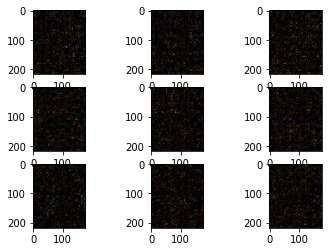

In [42]:
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(g_sample, feed_dict = {x_g: sample_Z(batch_size, g_dim)})
# gg = sess.run(discriminator(x_d), feed_dict = {x_d: batch(20, ls)})
gg_pic = np.array([np.reshape(m,(218,178,3)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.


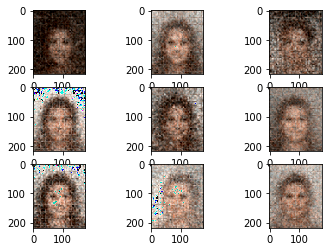

In [43]:
# gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(g_sample, feed_dict = {x_g: sample_Z(batch_size, g_dim)})
gg = sess.run(discriminator(x_d), feed_dict = {x_d: batch(20, ls)})
gg_pic = np.array([np.reshape(m,(218,178,3)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j])

In [44]:
for step in range(50001):
    batch_x = batch(batch_size, ls)
    z_D = sample_Z(batch_size, g_dim)
    sess.run([d_optimizer, g_optimizer], feed_dict={x_d: batch_x, x_g: z_D})
    z_G = sample_Z(batch_size, g_dim)
    sess.run(g_optimizer, feed_dict={x_g: z_G})
#     k_t = np.maximum(np.minimum(1., k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: z_G}))), 0.)
    sess.run(update_k, feed_dict={x_d: batch_x, x_g: z_G})
    if step%100==0:
        d_loss_train, g_loss_train, M_global_train = sess.run([d_loss, g_loss, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#         print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', sess.run(k_t),"M_global:", M_global_train

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.


step: 0  d-loss: 0.152473  g-loss: 0.0801827 k_t: 0.0160627 M_global: 0.157063
step: 100  d-loss: 0.161849  g-loss: 0.0799858 k_t: 0.0160279 M_global: 0.164711
step: 200  d-loss: 0.161486  g-loss: 0.0806142 k_t: 0.0160242 M_global: 0.163552
step: 300  d-loss: 0.159965  g-loss: 0.0807751 k_t: 0.0160654 M_global: 0.161406
step: 400  d-loss: 0.161238  g-loss: 0.0795512 k_t: 0.0160432 M_global: 0.164221
step: 500  d-loss: 0.15813  g-loss: 0.0795555 k_t: 0.0160416 M_global: 0.159554
step: 600  d-loss: 0.163134  g-loss: 0.0800899 k_t: 0.0160701 M_global: 0.166542
step: 700  d-loss: 0.157526  g-loss: 0.0796822 k_t: 0.0160365 M_global: 0.159084
step: 800  d-loss: 0.157746  g-loss: 0.0792143 k_t: 0.0160856 M_global: 0.159317
step: 900  d-loss: 0.161429  g-loss: 0.0802841 k_t: 0.0160743 M_global: 0.163795
step: 1000  d-loss: 0.15605  g-loss: 0.0796222 k_t: 0.0160371 M_global: 0.158285
step: 1100  d-loss: 0.152455  g-loss: 0.0803767 k_t: 0.0160595 M_global: 0.157249
step: 1200  d-loss: 0.157054  

step: 10100  d-loss: 0.151567  g-loss: 0.0796346 k_t: 0.0147358 M_global: 0.156005
step: 10200  d-loss: 0.152721  g-loss: 0.0784269 k_t: 0.014711 M_global: 0.155364
step: 10300  d-loss: 0.153439  g-loss: 0.079532 k_t: 0.0146496 M_global: 0.156834
step: 10400  d-loss: 0.155459  g-loss: 0.0781974 k_t: 0.0146014 M_global: 0.156704
step: 10500  d-loss: 0.156472  g-loss: 0.0783721 k_t: 0.014556 M_global: 0.158046
step: 10600  d-loss: 0.15812  g-loss: 0.0788256 k_t: 0.0145461 M_global: 0.160075
step: 10700  d-loss: 0.15151  g-loss: 0.0786171 k_t: 0.014449 M_global: 0.15494
step: 10800  d-loss: 0.15305  g-loss: 0.0795207 k_t: 0.0144299 M_global: 0.156619
step: 10900  d-loss: 0.159219  g-loss: 0.0781596 k_t: 0.0143583 M_global: 0.162352
step: 11000  d-loss: 0.151347  g-loss: 0.0783875 k_t: 0.0143501 M_global: 0.154623
step: 11100  d-loss: 0.152796  g-loss: 0.0795279 k_t: 0.014334 M_global: 0.156496
step: 11200  d-loss: 0.150896  g-loss: 0.078666 k_t: 0.014322 M_global: 0.154677
step: 11300  d-

step: 20100  d-loss: 0.151082  g-loss: 0.0781604 k_t: 0.0137232 M_global: 0.154238
step: 20200  d-loss: 0.150991  g-loss: 0.0773174 k_t: 0.0137431 M_global: 0.153344
step: 20300  d-loss: 0.151367  g-loss: 0.077083 k_t: 0.0137278 M_global: 0.153295
step: 20400  d-loss: 0.156062  g-loss: 0.0769331 k_t: 0.0137341 M_global: 0.158744
step: 20500  d-loss: 0.1495  g-loss: 0.0775707 k_t: 0.0137119 M_global: 0.152852
step: 20600  d-loss: 0.151803  g-loss: 0.0778351 k_t: 0.0137163 M_global: 0.15427
step: 20700  d-loss: 0.156817  g-loss: 0.0779624 k_t: 0.0136501 M_global: 0.15886
step: 20800  d-loss: 0.157859  g-loss: 0.0774157 k_t: 0.0136742 M_global: 0.160961
step: 20900  d-loss: 0.160368  g-loss: 0.0788525 k_t: 0.0136683 M_global: 0.163316
step: 21000  d-loss: 0.152241  g-loss: 0.077679 k_t: 0.0136635 M_global: 0.15433
step: 21100  d-loss: 0.157831  g-loss: 0.0785054 k_t: 0.0136118 M_global: 0.159844
step: 21200  d-loss: 0.154572  g-loss: 0.0791284 k_t: 0.0135323 M_global: 0.15695
step: 21300 

step: 30100  d-loss: 0.152836  g-loss: 0.0751335 k_t: 0.0129438 M_global: 0.155579
step: 30200  d-loss: 0.148746  g-loss: 0.0760277 k_t: 0.0130898 M_global: 0.150898
step: 30300  d-loss: 0.151439  g-loss: 0.0753827 k_t: 0.0132107 M_global: 0.15327
step: 30400  d-loss: 0.153212  g-loss: 0.0773301 k_t: 0.0133416 M_global: 0.154452
step: 30500  d-loss: 0.153997  g-loss: 0.0766979 k_t: 0.0129848 M_global: 0.155791
step: 30600  d-loss: 0.150925  g-loss: 0.0764321 k_t: 0.0131358 M_global: 0.152397
step: 30700  d-loss: 0.15221  g-loss: 0.075898 k_t: 0.0133144 M_global: 0.153933
step: 30800  d-loss: 0.149362  g-loss: 0.0751898 k_t: 0.0134241 M_global: 0.150376
step: 30900  d-loss: 0.148175  g-loss: 0.0753233 k_t: 0.013454 M_global: 0.149918
step: 31000  d-loss: 0.149077  g-loss: 0.0772427 k_t: 0.0134367 M_global: 0.1523
step: 31100  d-loss: 0.15543  g-loss: 0.0771221 k_t: 0.0135115 M_global: 0.157586
step: 31200  d-loss: 0.151644  g-loss: 0.077882 k_t: 0.0134688 M_global: 0.154229
step: 31300 

step: 40100  d-loss: 0.146176  g-loss: 0.077825 k_t: 0.0131134 M_global: 0.151423
step: 40200  d-loss: 0.142717  g-loss: 0.0771345 k_t: 0.0130434 M_global: 0.148996
step: 40300  d-loss: 0.157849  g-loss: 0.0768194 k_t: 0.0130586 M_global: 0.161459
step: 40400  d-loss: 0.151501  g-loss: 0.0810227 k_t: 0.0129615 M_global: 0.157298
step: 40500  d-loss: 0.15511  g-loss: 0.0750145 k_t: 0.0127481 M_global: 0.159085
step: 40600  d-loss: 0.148385  g-loss: 0.0746288 k_t: 0.0128401 M_global: 0.149385
step: 40700  d-loss: 0.153111  g-loss: 0.0749825 k_t: 0.0129754 M_global: 0.156144
step: 40800  d-loss: 0.155019  g-loss: 0.0771522 k_t: 0.0130796 M_global: 0.156891
step: 40900  d-loss: 0.148806  g-loss: 0.0808293 k_t: 0.0126435 M_global: 0.155743
step: 41000  d-loss: 0.148935  g-loss: 0.0746425 k_t: 0.0126933 M_global: 0.150181
step: 41100  d-loss: 0.149356  g-loss: 0.0747664 k_t: 0.0128721 M_global: 0.150711
step: 41200  d-loss: 0.151761  g-loss: 0.0753107 k_t: 0.0130093 M_global: 0.1538
step: 41

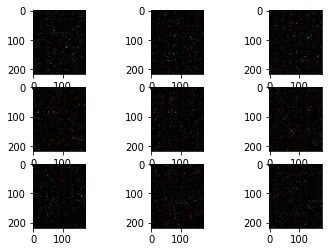

In [45]:
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(g_sample, feed_dict = {x_g: sample_Z(batch_size, g_dim)})
# gg = sess.run(discriminator(x_d), feed_dict = {x_d: batch(20, ls)})
gg_pic = np.array([np.reshape(m,(218,178,3)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.


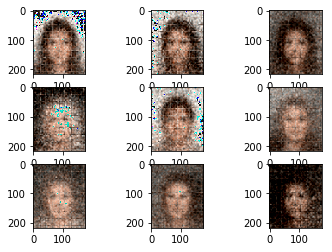

In [46]:
# gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(g_sample, feed_dict = {x_g: sample_Z(batch_size, g_dim)})
gg = sess.run(discriminator(x_d), feed_dict = {x_d: batch(20, ls)})
gg_pic = np.array([np.reshape(m,(218,178,3)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j])

In [47]:
for step in range(100001):
    batch_x = batch(batch_size, ls)
    z_D = sample_Z(batch_size, g_dim)
    sess.run([d_optimizer, g_optimizer], feed_dict={x_d: batch_x, x_g: z_D})
    z_G = sample_Z(batch_size, g_dim)
    sess.run(g_optimizer, feed_dict={x_g: z_G})
#     k_t = np.maximum(np.minimum(1., k_t + 0.001*(sess.run(balancer, feed_dict={x_d: batch_x, x_g: z_G}))), 0.)
    sess.run(update_k, feed_dict={x_d: batch_x, x_g: z_G})
    if step%100==0:
        d_loss_train, g_loss_train, M_global_train = sess.run([d_loss, g_loss, M_global], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#         print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', k_t,"M_global:", M_global_train
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train, 'k_t:', sess.run(k_t),"M_global:", M_global_train

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.


step: 0  d-loss: 0.1521  g-loss: 0.0757566 k_t: 0.0128014 M_global: 0.153848
step: 100  d-loss: 0.150947  g-loss: 0.0759302 k_t: 0.0127851 M_global: 0.151947
step: 200  d-loss: 0.144234  g-loss: 0.0768839 k_t: 0.0127067 M_global: 0.149489
step: 300  d-loss: 0.146863  g-loss: 0.075991 k_t: 0.0127323 M_global: 0.149906
step: 400  d-loss: 0.154024  g-loss: 0.0751686 k_t: 0.0126873 M_global: 0.157298
step: 500  d-loss: 0.153684  g-loss: 0.0758198 k_t: 0.0127079 M_global: 0.156152
step: 600  d-loss: 0.154298  g-loss: 0.0741391 k_t: 0.0128732 M_global: 0.15874
step: 700  d-loss: 0.152247  g-loss: 0.0736245 k_t: 0.0129935 M_global: 0.156181
step: 800  d-loss: 0.146242  g-loss: 0.0719977 k_t: 0.0133167 M_global: 0.148803
step: 900  d-loss: 0.152338  g-loss: 0.0802311 k_t: 0.0129464 M_global: 0.156919
step: 1000  d-loss: 0.150088  g-loss: 0.0736001 k_t: 0.0128567 M_global: 0.152951
step: 1100  d-loss: 0.150076  g-loss: 0.0737143 k_t: 0.0130045 M_global: 0.152837
step: 1200  d-loss: 0.152671  g-

step: 10100  d-loss: 0.153083  g-loss: 0.0739354 k_t: 0.0143158 M_global: 0.157277
step: 10200  d-loss: 0.142141  g-loss: 0.0740509 k_t: 0.0144392 M_global: 0.145656
step: 10300  d-loss: 0.146099  g-loss: 0.073882 k_t: 0.0145099 M_global: 0.147468
step: 10400  d-loss: 0.149394  g-loss: 0.0745888 k_t: 0.014586 M_global: 0.151134
step: 10500  d-loss: 0.151925  g-loss: 0.0747049 k_t: 0.0146325 M_global: 0.154822
step: 10600  d-loss: 0.154571  g-loss: 0.0749001 k_t: 0.0146702 M_global: 0.158605
step: 10700  d-loss: 0.141785  g-loss: 0.0745162 k_t: 0.0147005 M_global: 0.145957
step: 10800  d-loss: 0.151125  g-loss: 0.074309 k_t: 0.014778 M_global: 0.154026
step: 10900  d-loss: 0.145484  g-loss: 0.0740637 k_t: 0.0148723 M_global: 0.147357
step: 11000  d-loss: 0.148413  g-loss: 0.0727975 k_t: 0.0149948 M_global: 0.151459
step: 11100  d-loss: 0.146113  g-loss: 0.0721742 k_t: 0.0152501 M_global: 0.148646
step: 11200  d-loss: 0.150121  g-loss: 0.069829 k_t: 0.015665 M_global: 0.156993
step: 1130

step: 20100  d-loss: 0.147228  g-loss: 0.0743515 k_t: 0.0857809 M_global: 0.156058
step: 20200  d-loss: 0.144775  g-loss: 0.0743842 k_t: 0.0858517 M_global: 0.152357
step: 20300  d-loss: 0.145013  g-loss: 0.0743044 k_t: 0.0859013 M_global: 0.152789
step: 20400  d-loss: 0.136545  g-loss: 0.0744441 k_t: 0.085971 M_global: 0.145917
step: 20500  d-loss: 0.14754  g-loss: 0.07451 k_t: 0.0860117 M_global: 0.156412
step: 20600  d-loss: 0.141097  g-loss: 0.0749749 k_t: 0.0860315 M_global: 0.148749
step: 20700  d-loss: 0.144111  g-loss: 0.0746356 k_t: 0.0860418 M_global: 0.151164
step: 20800  d-loss: 0.145109  g-loss: 0.0749221 k_t: 0.0860593 M_global: 0.152414
step: 20900  d-loss: 0.145768  g-loss: 0.074974 k_t: 0.0860582 M_global: 0.153356
step: 21000  d-loss: 0.140655  g-loss: 0.0750467 k_t: 0.0860729 M_global: 0.148604
step: 21100  d-loss: 0.143778  g-loss: 0.0752024 k_t: 0.0860546 M_global: 0.150327
step: 21200  d-loss: 0.134152  g-loss: 0.0757934 k_t: 0.0860297 M_global: 0.14613
step: 2130

step: 30100  d-loss: 0.143802  g-loss: 0.0765548 k_t: 0.0699174 M_global: 0.151132
step: 30200  d-loss: 0.142795  g-loss: 0.0764458 k_t: 0.0697099 M_global: 0.150508
step: 30300  d-loss: 0.150388  g-loss: 0.0769197 k_t: 0.0695155 M_global: 0.156682
step: 30400  d-loss: 0.145924  g-loss: 0.0768076 k_t: 0.0692848 M_global: 0.15243
step: 30500  d-loss: 0.13872  g-loss: 0.0773333 k_t: 0.0690975 M_global: 0.149365
step: 30600  d-loss: 0.13954  g-loss: 0.0767466 k_t: 0.0688948 M_global: 0.149161
step: 30700  d-loss: 0.142675  g-loss: 0.0772639 k_t: 0.0686974 M_global: 0.151255
step: 30800  d-loss: 0.140921  g-loss: 0.0764529 k_t: 0.068514 M_global: 0.149532
step: 30900  d-loss: 0.143416  g-loss: 0.0765134 k_t: 0.068332 M_global: 0.150836
step: 31000  d-loss: 0.14716  g-loss: 0.0768687 k_t: 0.0681444 M_global: 0.153068
step: 31100  d-loss: 0.145253  g-loss: 0.0767598 k_t: 0.0679163 M_global: 0.151993
step: 31200  d-loss: 0.143155  g-loss: 0.0764372 k_t: 0.0677281 M_global: 0.150603


ValueError: cannot reshape array of size 1 into shape (116412,)

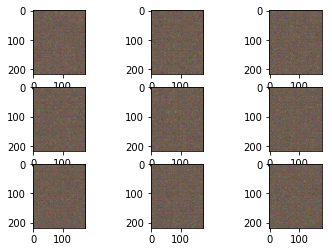

In [48]:
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(g_sample, feed_dict = {x_g: sample_Z(batch_size, g_dim)})
# gg = sess.run(discriminator(x_d), feed_dict = {x_d: batch(20, ls)})
gg_pic = np.array([np.reshape(m,(218,178,3)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.


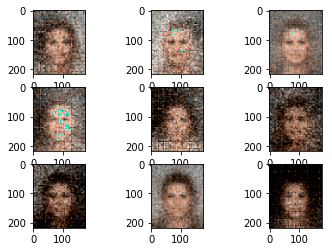

In [63]:
# gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(g_sample, feed_dict = {x_g: sample_Z(batch_size, g_dim)})
gg_batch = batch(20, ls)
gg = sess.run(discriminator(x_d), feed_dict = {x_d: gg_batch})
gg_pic = np.array([np.reshape(m,(218,178,3)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.


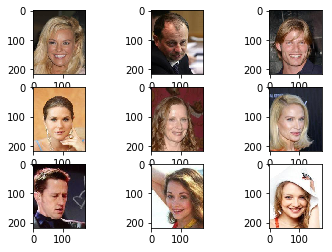

In [65]:
# gg_batch = batch(20, ls)
gg_batch = batch(20, ls)
gg_pic = np.array([np.reshape(m,(218,178,3)) for m in gg_batch])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j])

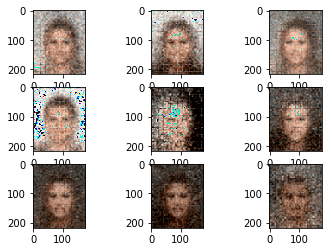

In [62]:
gg = sess.run(discriminator(x_d), feed_dict = {x_d: gg_batch})
gg_pic = np.array([np.reshape(m,(218,178,3)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j])